In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
# Dataset Directory
PATH = "../Dataset"

# Training Dataset Directory
DATA_DIR_TRAIN = "/Training Set"
# Testing Dataset Directory
DATA_DIR_TEST = "/Testing Set"

# full path
DATA_DIR_TRAIN = PATH + DATA_DIR_TRAIN
DATA_DIR_TEST = PATH + DATA_DIR_TEST

# List of training and validation patient list
train_val_patient_list = os.listdir(DATA_DIR_TRAIN)

#List of testing patients list
test_patient_list = os.listdir(DATA_DIR_TEST)

print(len(train_val_patient_list))
print(len(test_patient_list))

100
54


In [3]:
from sklearn.model_selection import train_test_split

# Spliting the training dataset to 80% training and 20% validation data
training_dir, validation_dir = train_test_split(train_val_patient_list, test_size=0.2, random_state=20)

print(len(training_dir))
print(len(validation_dir))

80
20


In [4]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [5]:
class AtriaDataset(Dataset):
    def __init__(self, dataset_dir, patient_list, augmentation=None, preprocessing=None):
        
        self.patient_list = patient_list
        self.patient_path_list = sorted([os.path.join(dataset_dir, pid) 
                                         for pid in patient_list])
        self.image_folder_list = [os.path.join(patient_path, "Images") 
                                  for patient_path in self.patient_path_list]
        self.label_folder_list = [os.path.join(patient_path, "Labels") 
                                  for patient_path in self.patient_path_list]
        
        self.mri_image = []
        
        for file_name in self.image_folder_list:
            images = os.listdir(file_name)
            for img in images:
                self.mri_image.append(os.path.join(file_name, img))

        self.mri_image.sort()

        self.mask = []
        
        for file_name in self.label_folder_list:
            labels = os.listdir(file_name)
            for label in labels:
                self.mask.append(os.path.join(file_name, label))

        self.mask.sort()
        
        self.full_list = sorted((self.mri_image[i], self.mask[i]) 
                                for i in range(len(self.mri_image)))
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.data_size = len(self.full_list)
    
    
    def __getitem__(self, index):
        
        image = cv2.imread(self.full_list[index][0],0)
        mask = cv2.imread(self.full_list[index][1],0)
        image = cv2.resize(image, (576,576), interpolation = cv2.INTER_AREA)
        mask = cv2.resize(mask, (576,576), interpolation = cv2.INTER_AREA)
        image = image[:, :, np.newaxis]
        mask = mask[:, :, np.newaxis]
        #print(mask.shape)
        
        mask[mask>0] = 1
        '''thresh, mask = cv2.threshold(mask,128,255,cv2.THRESH_BINARY)
        mask = mask/255
        mask = np.expand_dims(mask, axis=2)'''
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
    
    
    def __len__(self):
        return self.data_size

In [78]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    pic_name = ""
    if n==4:
        pic_name = images.pop('pic_name', 'No Key found')
        n = n-1
    fig_image = plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        x = image
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        if i == 0:
            plt.ylabel("MANet")
        plt.title(' '.join(name.split('_')).title())
        if x.shape[0]==1:
            x = x.transpose(1,2,0)
        plt.imshow(x)
    plt.show()
    if pic_name:
        fig_image.savefig(pic_name+'.png')
    fig_image.savefig('prediction.png')

In [7]:
import albumentations as albu

In [8]:
def get_training_augmentation():
    train_transform = [
        albu.HorizontalFlip(p=0.8),
        albu.ShiftScaleRotate(scale_limit=0.5, shift_limit=0.0625, rotate_limit=45, p=0.2),
        albu.RandomBrightnessContrast(p=0.8),
        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),
        
        albu.OneOf(
            [
                albu.Sharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    #print(type(x))
    return x.transpose(2, 0, 1).astype('float32')

def conv_mask(x, **kwargs):
    thresh, img = cv2.threshold(x,128,255,cv2.THRESH_BINARY)
    img = img/255
    img = np.expand_dims(img, axis=2)
    return img

def std_image(x, **kwargs):
    mean=np.mean(x)
    std=np.std(x)
    eps = 1e-5
    if std == 0:
        std = std+eps
    x = (x - mean)/std
    return x

def norm_image(x, **kwargs):
    x = x/255
    return x


def get_preprocessing():
    _transform = [
        albu.Lambda(image=norm_image),
        albu.Lambda(image=to_tensor, mask=to_tensor)
    ]
    return albu.Compose(_transform)

In [9]:
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils.metrics as smp_metrics
import segmentation_models_pytorch.utils.losses as smp_losses

In [10]:
import torch.nn as nn
import monai
from monai.metrics import DiceMetric, MeanIoU, HausdorffDistanceMetric, SurfaceDistanceMetric

In [11]:
train_dataset = AtriaDataset(DATA_DIR_TRAIN, training_dir,
                                 augmentation=get_training_augmentation(),
                                 preprocessing=get_preprocessing())

valid_dataset = AtriaDataset(DATA_DIR_TRAIN, validation_dir,
                                 preprocessing=get_preprocessing())

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, num_workers=4)

In [80]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.MAnet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS,
    in_channels = 1,
    activation=ACTIVATION,
)

In [81]:
loss = smp.utils.losses.DiceLoss()
extra_metric = smp.utils.losses.DiceLoss()
#loss = monai.losses.DiceLoss(sigmoid=True)
metrics = [smp.utils.metrics.IoU(threshold=0.5),]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=1e-5),
])

In [15]:
import sys
import torch
from tqdm import tqdm as tqdm

In [16]:
class Meter(object):
    """Meters provide a way to keep track of important statistics in an online manner.
    This class is abstract, but provides a standard interface for all meters to follow.
    """

    def reset(self):
        """Reset the meter to default settings."""
        pass

    def add(self, value):
        """Log a new value to the meter
        Args:
            value: Next result to include.
        """
        pass

    def value(self):
        """Get the value of the meter in the current state."""
        pass


class AverageValueMeter(Meter):
    def __init__(self):
        super(AverageValueMeter, self).__init__()
        self.reset()
        self.val = 0

    def add(self, value, n=1):
        self.val = value
        self.sum += value
        self.var += value * value
        self.n += n

        if self.n == 0:
            self.mean, self.std = np.nan, np.nan
        elif self.n == 1:
            self.mean = 0.0 + self.sum  # This is to force a copy in torch/numpy
            self.std = np.inf
            self.mean_old = self.mean
            self.m_s = 0.0
        else:
            self.mean = self.mean_old + (value - n * self.mean_old) / float(self.n)
            self.m_s += (value - self.mean_old) * (value - self.mean)
            self.mean_old = self.mean
            self.std = np.sqrt(self.m_s / (self.n - 1.0))

    def value(self):
        return self.mean, self.std

    def reset(self):
        self.n = 0
        self.sum = 0.0
        self.var = 0.0
        self.val = 0.0
        self.mean = np.nan
        self.mean_old = 0.0
        self.m_s = 0.0
        self.std = np.nan

In [43]:
class Epoch:
    def __init__(self, model, loss, metrics, extra_metric, stage_name, device="cpu", verbose=True):
        self.model = model
        self.loss = loss
        self.metrics = metrics
        self.extra_metric = extra_metric
        self.stage_name = stage_name
        self.verbose = verbose
        self.device = device

        self._to_device()

    def _to_device(self):
        self.model.to(self.device)
        self.loss.to(self.device)
        self.extra_metric.to(self.device)
        for metric in self.metrics:
            metric.to(self.device)

    def _format_logs(self, logs):
        str_logs = ["{} - {:.4f}".format(k, v) for k, v in logs.items()]
        s = ", ".join(str_logs)
        return s

    def batch_update(self, x, y):
        raise NotImplementedError

    def on_epoch_start(self):
        pass

    def run(self, dataloader, epoch_loss=0, step=0):
        
        #dice_metric = DiceMetric(include_background=True, reduction="mean")
        #iou = MeanIoU(include_background=True, reduction="mean")
        hauf_dis = HausdorffDistanceMetric(include_background=False, distance_metric='euclidean',
                                           reduction="mean")
        surface_dis = SurfaceDistanceMetric(include_background=False, symmetric = True,
                                            distance_metric='euclidean', reduction="mean")
        #msd_score = 0
        #hd_score = 0
        self.on_epoch_start()               
        
        logs = {}
        logs_print = {}
        loss_meter = AverageValueMeter()
        dice_meter = AverageValueMeter()
        metrics_meters = {metric.__name__: AverageValueMeter() for metric in self.metrics}
        flag = 0                                    
        with tqdm(
            dataloader,
            desc=self.stage_name,
            file=sys.stdout,
            disable=not (self.verbose),
        ) as iterator:
            for x, y in iterator:
                #step += 1
                x, y = x.to(self.device), y.to(self.device)
                loss, y_pred = self.batch_update(x, y)

                #y_pred = torch.sigmoid(y_pred)

                # update loss logs
                #epoch_loss += loss.item()
                loss_value = loss.cpu().detach().numpy()
                loss_meter.add(loss_value)
                loss_logs = {self.loss.__name__: loss_meter.mean}

                dice_loss = self.extra_metric(y_pred, y)
                dice = dice_loss.cpu().detach().numpy()
                dice_score = 1-dice

                dice_meter.add(dice_score)
                dice_logs = {"dice_score": dice_meter.mean}
                logs.update(loss_logs)
                logs_print.update(loss_logs)
                logs.update(dice_logs)
                logs_print.update(dice_logs)
                #dice_metric(y_pred=y_pred, y=y)
                #iou(y_pred=y_pred, y=y)
                
                for metric_fn in self.metrics:
                    metric_value = metric_fn(y_pred, y).cpu().detach().numpy()
                    metrics_meters[metric_fn.__name__].add(metric_value)
                metrics_logs = {k: v.mean for k, v in metrics_meters.items()}
                logs.update(metrics_logs)
                logs_print.update(metrics_logs)

                if self.verbose:
                    lg_pr = self._format_logs(logs_print)
                    iterator.set_postfix_str(lg_pr)
                
                y_pred[y_pred>=0.4] = 1
                y_pred[y_pred<0.4] = 0

                count = (y == 1).sum()
                count_pred = (y_pred == 1).sum()
                
                '''y_pred = y_pred.squeeze().cpu().detach().numpy()
                y = y.squeeze().cpu().detach().numpy()
                
                visualize(
                    ground_truth_mask= y, 
                    predicted_mask=y_pred,
                )
                break'''
                
                if count<3:
                    continue
                
                elif count_pred<1:
                    continue
                
                flag = 1
                hauf_dis(y_pred=y_pred, y=y)
                surface_dis(y_pred=y_pred, y=y)
                #surface_distance = surfd(y_pred, y)
                
                #msd = surface_distance.mean()
                #hd  = surface_distance.max()
                
                #msd_score = msd_score + msd
                #hd_score = hd_score + hd
                
                '''if y_pred
                
                labels = [1]
                y_pred[y_pred>=0.5]=1
                y_pred[y_pred<0.5]=0
                csv_file = None # or None if do not want to save metrics to csv file
                metrics = sg.write_metrics(labels=labels,  # exclude background if needed
                                           gdth_img=y,
                                           pred_img=y_pred,
                                           csv_file=csv_file,
                                           metrics=['hd', 'msd'])
                print(metrics)'''
                
            #epoch_loss /= step
            #msd_score /= step
            #hd_score /= step
            #loss_logs = {"dice_loss": epoch_loss}
            #logs.update(loss_logs)
            
            #dice_score = dice_metric.aggregate().item()
            #dice_metric.reset()
            
            #iou_score = iou.aggregate().item()
            #iou.reset()
            
            #iou_metric_values.append(iou_score)
            if flag == 1:
                hauf_sc = hauf_dis.aggregate().item()
                hauf_score = hauf_sc
                hauf_dis.reset()
                
                sur_sc = surface_dis.aggregate().item()
                sur_score = sur_sc
                surface_dis.reset()
            
            else:
                hauf_score = 999
                sur_score = 999

            hauf_logs = {"hauf": hauf_score}
            logs.update(hauf_logs)
            sur_logs = {"surface": sur_score}
            logs.update(sur_logs)
            
            s = self._format_logs(logs)
            print(s)

        return logs


class TrainEpoch(Epoch):
    def __init__(self, model, loss, metrics, extra_metric, optimizer, device="cpu", verbose=True):
        super().__init__(
            model=model,
            loss=loss,
            metrics=metrics,
            extra_metric=extra_metric,
            stage_name="train",
            device=device,
            verbose=verbose,
        )
        self.optimizer = optimizer

    def on_epoch_start(self):
        self.model.train()

    def batch_update(self, x, y):
        self.optimizer.zero_grad()
        prediction = self.model.forward(x)
        loss = self.loss(prediction, y)
        loss.backward()
        self.optimizer.step()
        return loss, prediction


class ValidEpoch(Epoch):
    def __init__(self, model, loss, metrics, extra_metric, device="cpu", verbose=True):
        super().__init__(
            model=model,
            loss=loss,
            metrics=metrics,
            extra_metric=extra_metric,
            stage_name="valid",
            device=device,
            verbose=verbose,
        )

    def on_epoch_start(self):
        self.model.eval()

    def batch_update(self, x, y):
        with torch.no_grad():
            prediction = self.model.forward(x)
            loss = self.loss(prediction, y)
        return loss, prediction

In [83]:
# load best saved checkpoint
best_model = torch.load('./best_model_MAnet_dice_norm.pth')

In [86]:
# create test dataset
test_dataset_vis = AtriaDataset(DATA_DIR_TEST, test_patient_list,
                           preprocessing=get_preprocessing())

test_dataset = AtriaDataset(DATA_DIR_TEST, test_patient_list)

test_dataloader = DataLoader(test_dataset_vis)

# evaluate model on test set
test_epoch = ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    extra_metric=extra_metric,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|█████████████████████| 4752/4752 [02:03<00:00, 38.54it/s, dice_loss - 0.1364, dice_score - 0.8636, iou_score - 0.8191]
dice_loss - 0.1364, dice_score - 0.8636, iou_score - 0.8191, hauf - 17.6335, surface - 3.2465


(576, 576, 1)
136


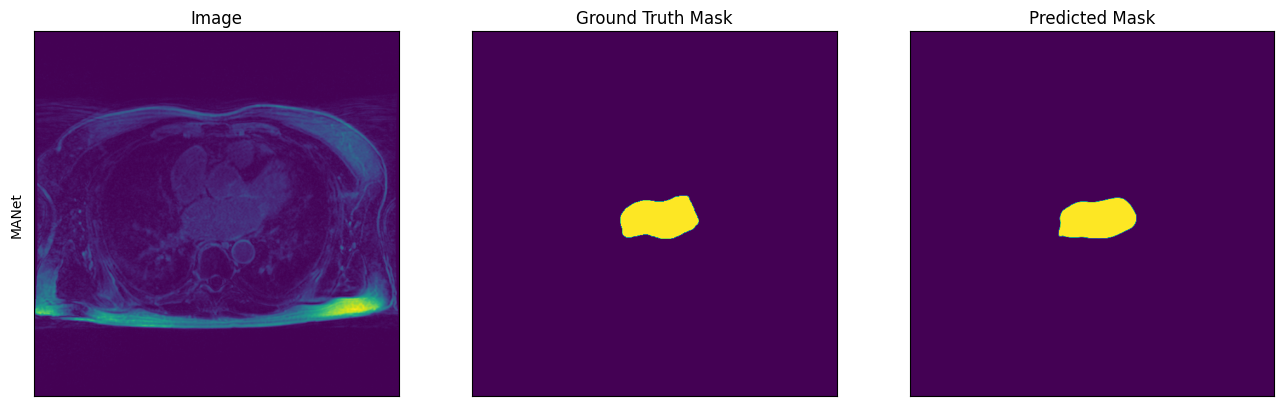

In [85]:
for i in range(1):
    #n = np.random.choice(len(test_dataset))
    n = 219
    image_vis = test_dataset[n][0].astype('uint8')
    image, gt_mask = test_dataset_vis[n]
    gt_mask = gt_mask.squeeze()
    
    count = (gt_mask == 1).sum()
    if count<10:
        continue
    print(image_vis.shape)
    print(np.max(image_vis))
    #image = image.transpose(2,0,1).astype("float32")
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    best_model = best_model.eval()
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy())
    pic_name = "prediction_MAnet"+str(i)
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask,
        pic_name = pic_name
    )